# Code for making predictions with and without news features

In [1]:
# !pip install statsmodels

## Libraries/Data required

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score


# Import models
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

data_dir = "data/" # Define data path

In [3]:
df = pd.read_csv(data_dir + "food_crises_cleaned.csv") # Read data into DataFrame
df["date"] = pd.to_datetime(df["year_month"], format="%Y_%m") # Create date column
print(len(df['district'].unique()))
df.set_index(["date", "district"], inplace=True) # Set index

78


In [4]:

df_topics = pd.read_csv(data_dir + "articles_topics.csv",parse_dates=True)

In [5]:
df_topics['date'] = pd.to_datetime(df_topics['date'], format='%Y-%m-%d')

In [6]:
df_topics.columns

Index(['summary', 'date', 'location_article', 'lat', 'lng', 'hunger',
       'refugees', 'humanitarian', 'conflict'],
      dtype='object')

In [7]:
df_topics.groupby(df_topics['date'].dt.to_period('M'))['hunger'].sum()

date
2011-06     1
2011-07     3
2011-08    10
2011-09     5
2011-10    10
           ..
2022-12     0
2023-01     1
2023-02     0
2023-03     2
2023-04     0
Freq: M, Name: hunger, Length: 143, dtype: int64

In [8]:
df1 = df_topics.groupby(df_topics['date'].dt.to_period('M'))['hunger'].sum()
df1 = df1.resample('M').asfreq().fillna(0)

<Axes: xlabel='date'>

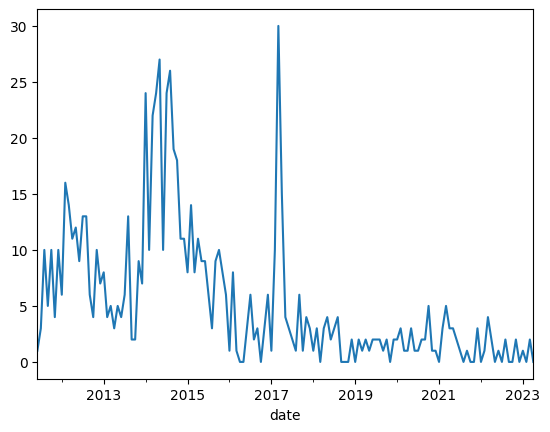

In [9]:
df1.plot()

## Basic visualizations

<br>
A bar chart showing the frequency of the different "fews_ipc" phases.

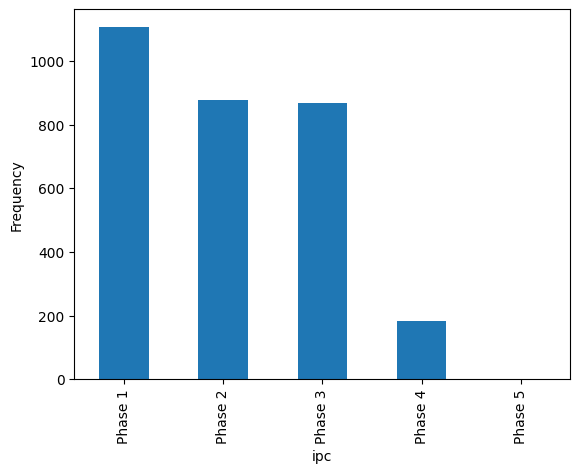

In [10]:
ax = df["ipc"].value_counts().plot(kind="bar") # Initialize barplot of fews_ipc counts
ax.set_xticklabels(["Phase {}".format(i) for i in range(1, 6)]) # Label the phases
ax.set_ylabel('Frequency'); # Set y label

<br>
A map of South Sudan showing the mean IPC per county (with geopandas).

C:\Users\Lucas\AppData\Local\Temp\ipykernel_18512\480331542.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")) # Get map of the world
C:\Users\Lucas\anaconda3_new\envs\dc3\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


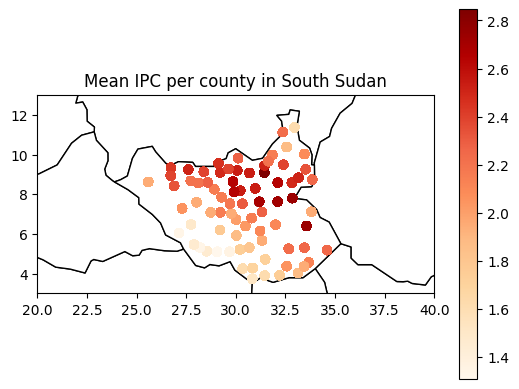

In [11]:
# Plot map of south sudan
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")) # Get map of the world

ax = world.plot(color="white", edgecolor="black") # Plot world map

# Bound map to south sudan
ax.set_xlim(20, 40)
ax.set_ylim(3, 13)

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["centx"], df["centy"])) # Initialize GeoDataFrame

# Calculate mean ipc per administration
mean_ipc = (
    df.reset_index()[["ipc", "district"]]
    .groupby("district")
    .mean()
    .rename(columns={"ipc": "mean_ipc"})
)

# Plot mean ipc per administration on map
gdf.merge(mean_ipc, on="district").plot(
    column="mean_ipc", ax=ax, legend=True, cmap="OrRd"
)

# Set plot title
ax.set_title("Mean IPC per county in South Sudan");

In [12]:
!pip install geopandas

<BR>

## Helper Functions

Here we define a function that lags input variables. There are options for creating a rolling mean, taking the difference between subsequent rows, and dropping NaNs. Feature engineering can of course be extended much further than this.

In [13]:
def create_lag_df(df, columns, lag, difference=False, rolling=None, dropna=False):
    '''
    Function to add lagged colums to dataframe
    
    Inputs:
        df - Dataframe
        columns - List of columns to create lags from
        lag - The number of timesteps (in months for the default data) to lag the variable by
        difference - Whether to take the difference between each observation as new column
        rolling - The size of the rolling mean window, input None type to not use a rolling variable
        dropna - Whether to drop NaN values
        
    Output:
        df - Dataframe with the lagged columns added
    '''
    
    for column in columns:
        col = df[column].unstack()
        if rolling:
            col = col.rolling(rolling).mean()
        if difference:
            col = col.diff()
        if dropna:
            col = col.dropna(how='any')
        df[f"{column}_lag_{lag}"] = col.shift(lag).stack()
    return df

<br>
Here we define a function that plots a confusion matrix given a prediction and the true values, it can be used both for binary and categorical variables.

In [14]:
def plot_ConfusionMatrix(prediction, true, binary=False):
    '''
    Function to plot a confusion matrix as a heatmap from a prediction and true values.
    
    Inputs:
        prediction - The predicted values
        true - the true values
        binary - whether the variable is binary or not
        
    Output:
        confusion_matrix - The calculated confusion matrix based on the prediction and true values.
        
        Also plots the confusion matrix as heatmap in an interactive environment such as Jupyter Notebook.
    '''
    
    y_pred = prediction
    
    if not binary:
        # Round prediction to nearest integer (i.e. the nearest phase)
        y_pred = y_pred.round() 
        y_pred = np.minimum(y_pred, 5) # Cap maximum prediction at 5 (maximum phase)
        y_pred = np.maximum(y_pred, 1) # Cap minimum prediction at 1 (minimum phase)

    # Initialize confusion matrix
    confusion_matrix = pd.crosstab(
        true, y_pred, rownames=["Actual"], colnames=["Predicted"]
    )

    # Plot confusion matrix as heatmap
    sns.heatmap(confusion_matrix, annot=True, fmt="g")
    plt.show()
    plt.clf()
    
    return confusion_matrix

## Making Predictions

To simplify, we treat the IPC prediction problem as regression rather than classification,
e.g., multivariable logistic regression might be more suited.
<br><br>
We use a TimeSeriesSplit to divide the data into 5 training-test splits and run cross-validation on these splits. 
<br>We report the confusion matrix (with training and test split as title) along with the model summary per split; the mean MAE and mean R2 are reported after completion of cross-validation.
<br><br>
First however, we create multiple lagged variables in the cell directly below.

In [15]:
df.columns

Index(['country', 'district_code', 'centx', 'centy', 'year_month', 'year',
       'month', 'ipc', 'ha', 'ndvi_mean', 'ndvi_anom', 'rain_mean',
       'rain_anom', 'et_mean', 'et_anom', 'count_violence', 'sum_fatalities',
       'food_price_idx', 'area', 'cropland_pct', 'pop', 'ruggedness_mean',
       'pasture_pct'],
      dtype='object')

## Additional data

In [16]:
# Create several lagged columns to use as explanatory variables for the model

df = create_lag_df(df, ['count_violence', 'ndvi_anom'], 3, rolling=6) # 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['food_price_idx'], 3, difference=True, rolling=6) # difference of the 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['ipc'], 1, dropna=True) # 1-month-lag
df = create_lag_df(df, ['ipc'], 2, dropna=True) # 2-month-lag
df = create_lag_df(df, ['ipc'], 3, dropna=True) # 3-month-lag
df = create_lag_df(df, ['pasture_pct'], 3, dropna=True) # 3-month-lag
df = create_lag_df(df, ['rain_anom'], 3, dropna=True) # 3-month-lag
df = create_lag_df(df, ['cropland_pct'], 3, dropna=True) # 3-month-lag
df = create_lag_df(df, ['ha'], 1, dropna=True) # 3-month-lag
df = create_lag_df(df, ['count_violence'], 1, dropna=True) # 3-month-lag
df.columns # View the newly created columns

Index(['country', 'district_code', 'centx', 'centy', 'year_month', 'year',
       'month', 'ipc', 'ha', 'ndvi_mean', 'ndvi_anom', 'rain_mean',
       'rain_anom', 'et_mean', 'et_anom', 'count_violence', 'sum_fatalities',
       'food_price_idx', 'area', 'cropland_pct', 'pop', 'ruggedness_mean',
       'pasture_pct', 'count_violence_lag_3', 'ndvi_anom_lag_3',
       'food_price_idx_lag_3', 'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3',
       'pasture_pct_lag_3', 'rain_anom_lag_3', 'cropland_pct_lag_3',
       'ha_lag_1', 'count_violence_lag_1'],
      dtype='object')

In [17]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column

In [18]:
# X = df.iloc[:, -6:] # Define explanatory variables
# X = sm.add_constant(X) # Add constant column of 1s for intercept
# y = df[["ipc"]] # Define target data

# cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# # Initinalize empty lists to score scores
# mae_values = list()
# r2_values = list()

# for train_index, val_index in cv.split(X): # Loop over the different training-test splits

#     # Define X and y data
#     X_train, X_test = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#     #Interpolate training data to generate more training points
#     X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
#     X_train.reset_index(level=0, drop=True, inplace=True)
#     y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
#     y_train.reset_index(level=0, drop=True, inplace=True)

#     model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data
#     results = model.fit() # Get model results on training data
#     print(results.summary()) # Print model summary

#     y_pred = results.predict(X_test) # Run model on test data
    
#     # Append results to respective lists
#     mae_values.append((y_pred - y_val['ipc']).abs().mean())
#     r2_values.append(results.rsquared)
    
#     plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
#     plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix
    
# print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
# print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2

## Incorporating News Features

We look at country wide news features to simplify. E.g., we do not look at topics per district

In [19]:
news_df = pd.read_csv(data_dir + "articles_topics.csv") # Read news data into DataFrame

# Create date column
news_df["date"] = pd.to_datetime(
    pd.to_datetime(news_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)

In [20]:
def create_news_features(columns):
    cols = []
    for column in columns:
        col = news_df.groupby(["date"])[column].mean()
        col = col.fillna(0)
        col = col.rolling(3).mean()
        col = col.shift(3)
        cols.append(col)
    return pd.concat(cols, axis=1)

### Visualization of news features over time

The 2017 South Sudan famine is very apparent. Most of this event needs to be predicted out-of-sample with the training/test split we chose.

More info on the famine : https://en.wikipedia.org/wiki/2017_South_Sudan_famine

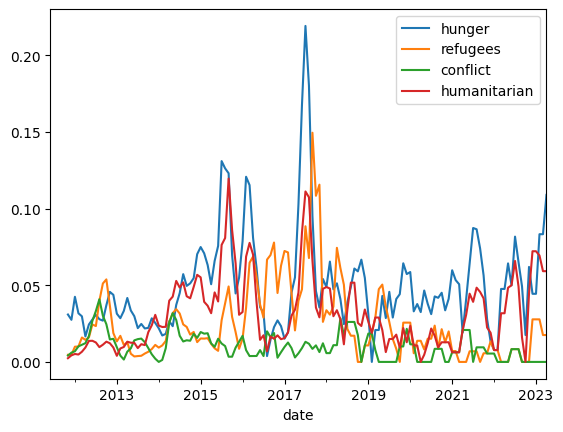

In [21]:
# country wide news features
news_features = create_news_features(["hunger", 'refugees', 'conflict', 'humanitarian'])

news_features.plot();

In [22]:
# # Get the mean share of articles per ipc for the different topics
# combined = (
#     pd.DataFrame(y['ipc'])
#     .join(news_df.groupby(["date"])["hunger"].mean())
#     .join(news_df.groupby(["date"])["refugees"].mean())
#     .join(news_df.groupby(["date"])["conflict"].mean())
#     .join(news_df.groupby(["date"])["humanitarian"].mean())
# )


# # Plot the mean share of articles per ipc value for the different topics
# combined.groupby("ipc")[["hunger", "refugees", "conflict", "humanitarian"]].mean().plot(
#     kind="bar", ylabel="Share of total articles"
# );

In [23]:
df.columns

Index(['country', 'district_code', 'centx', 'centy', 'year_month', 'year',
       'month', 'ipc', 'ha', 'ndvi_mean', 'ndvi_anom', 'rain_mean',
       'rain_anom', 'et_mean', 'et_anom', 'count_violence', 'sum_fatalities',
       'food_price_idx', 'area', 'cropland_pct', 'pop', 'ruggedness_mean',
       'pasture_pct', 'count_violence_lag_3', 'ndvi_anom_lag_3',
       'food_price_idx_lag_3', 'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3',
       'pasture_pct_lag_3', 'rain_anom_lag_3', 'cropland_pct_lag_3',
       'ha_lag_1', 'count_violence_lag_1'],
      dtype='object')

# Predicting using news features

In [24]:
df.columns

Index(['country', 'district_code', 'centx', 'centy', 'year_month', 'year',
       'month', 'ipc', 'ha', 'ndvi_mean', 'ndvi_anom', 'rain_mean',
       'rain_anom', 'et_mean', 'et_anom', 'count_violence', 'sum_fatalities',
       'food_price_idx', 'area', 'cropland_pct', 'pop', 'ruggedness_mean',
       'pasture_pct', 'count_violence_lag_3', 'ndvi_anom_lag_3',
       'food_price_idx_lag_3', 'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3',
       'pasture_pct_lag_3', 'rain_anom_lag_3', 'cropland_pct_lag_3',
       'ha_lag_1', 'count_violence_lag_1'],
      dtype='object')

In [25]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
df = df.join(news_features, how="left") # Join df with created news features

# Merge dataset

In [26]:
df_conflict = pd.read_csv("data\external_data\merged_data.csv", parse_dates=["date"])
df_conflict_clean = df_conflict[["district", "date", "conflict_count", "fatalities", "fatalities_per_pop", "fatalities_per_area", 
                                 "fatalities_per_poparea", "conflicts_per_pop", "conflicts_per_area", "conflicts_per_poparea"]].set_index(["date", "district"]).sort_index()
df_merge = df.merge(df_conflict_clean, left_index=True, right_index=True, how="left")

In [27]:
for var1 in ["conflict_count", "fatalities", "fatalities_per_pop", "fatalities_per_area", "fatalities_per_poparea", 
             "conflicts_per_pop", "conflicts_per_area", "conflicts_per_poparea"]:
    df_merge.loc["2012":, var1].fillna(0, inplace=True)

In [28]:
df_merge

country  district_code     centx     centy  \
date       district                                                       
2009-07-01 Abiemnhom     South Sudan            136  29.13019  9.550939   
           Akobo         South Sudan            114  32.85308  7.799214   
           Anzara        South Sudan             86  28.20598  5.309739   
           Aweil Center  South Sudan            128  26.89562  8.417934   
           Aweil East    South Sudan            141  27.61364  9.243139   
...                              ...            ...       ...       ...   
2020-02-01 Wulu          South Sudan            105  29.20889  6.200243   
           Yambio        South Sudan             82  28.54729  5.124909   
           Yei           South Sudan             81  30.34454  4.252148   
           Yirol East    South Sudan            107  30.80245  6.793194   
           Yirol West    South Sudan            101  30.48698  6.395244   

                        year_month  year  month  ipc   ha  ndvi_mean  ...  \
date       district                                                   ...   
2009-07-01 Abiemnhom       2009_07  2009      7  2.0  NaN   0.698165  ...   
           Akobo           2009_07  2009      7  4.0  NaN   0.474723  ...   
           Anzara          2009_07  2009      7  1.0  NaN   0.812001  ...   
           Aweil Center    2009_07  2009      7  2.0  NaN   0.723154  ...   
           Aweil East      2009_07  2009      7  3.0  NaN   0.547611  ...   
...                            ...   ...    ...  ...  ...        ...  ...   
2020-02-01 Wulu            2020_02  2020      2  2.0  0.0   0.374735  ...   
           Yambio          2020_02  2020      2  3.0  0.0   0.468085  ...   
           Yei             2020_02  2020      2  3.0  0.0   0.452878  ...   
           Yirol East      2020_02  2020      2  4.0  0.0   0.410408  ...   
           Yirol West      2020_02  2020      2  3.0  0.0   0.319411  ...   

                         conflict  humanitarian  conflict_count  fatalities  \
date       district                                                           
2009-07-01 Abiemnhom          NaN           NaN             NaN         NaN   
           Akobo              NaN           NaN             NaN         NaN   
           Anzara             NaN           NaN             NaN         NaN   
           Aweil Center       NaN           NaN             NaN         NaN   
           Aweil East         NaN           NaN             NaN         NaN   
...                           ...           ...             ...         ...   
2020-02-01 Wulu          0.011494      0.010753             0.0        0.00   
           Yambio        0.011494      0.010753             3.0        0.33   
           Yei           0.011494      0.010753             7.0        2.57   
           Yirol East    0.011494      0.010753             1.0        0.00   
           Yirol West    0.011494      0.010753             4.0        6.75   

                         fatalities_per_pop  fatalities_per_area  \
date       district                                                
2009-07-01 Abiemnhom                    NaN                  NaN   
           Akobo                        NaN                  NaN   
           Anzara                       NaN                  NaN   
           Aweil Center                 NaN                  NaN   
           Aweil East                   NaN                  NaN   
...                                     ...                  ...   
2020-02-01 Wulu                    0.000000             0.000000   
           Yambio                  0.000002             0.000037   
           Yei                     0.000009             0.000383   
           Yirol East              0.000000             0.000000   
           Yirol West              0.000060             0.001383   

                         fatalities_per_poparea  conflicts_per_pop  \
date       district                                                 

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import HistGradientBoostingRegressor

## Simpleimputer

In [30]:
df = df_merge.copy()

In [31]:
imputer = SimpleImputer()
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_num = df.select_dtypes(include=numerics)
df_obj = df.select_dtypes(exclude=numerics)
imputed_data = imputer.fit_transform(df_num)  # impute all the missing data
df_imputed = pd.DataFrame(imputed_data, index=df_num.index)
df_imputed=pd.concat([df_obj,df_imputed], ignore_index=True, axis=1).set_axis(df.columns.values, axis=1)

## Interpolation

In [32]:
df_interpolated = df.groupby('district', as_index=False).apply(lambda group: group.interpolate()).dropna()

Index(['sum_fatalities', 'food_price_idx', 'area', 'cropland_pct', 'pop',
       'ruggedness_mean', 'pasture_pct', 'count_violence_lag_3',
       'ndvi_anom_lag_3', 'food_price_idx_lag_3', 'ipc_lag_1', 'ipc_lag_2',
       'ipc_lag_3', 'pasture_pct_lag_3', 'rain_anom_lag_3',
       'cropland_pct_lag_3', 'ha_lag_1', 'count_violence_lag_1', 'hunger',
       'refugees', 'conflict', 'humanitarian', 'conflict_count', 'fatalities',
       'fatalities_per_pop', 'fatalities_per_area', 'fatalities_per_poparea',
       'conflicts_per_pop', 'conflicts_per_area', 'conflicts_per_poparea'],
      dtype='object')

## KNN regression

In [33]:
scaler=MinMaxScaler()

#KNN
X = df_imputed.iloc[:, -30:] # Define explanatory variables
scaler.fit(X.values)
X = pd.DataFrame(scaler.transform(X.values), columns=X.columns, index=X.index)

y = df_imputed[["ipc"]] # Define target data

X_raw = df.iloc[:, -30:] # Define explanatory variables # Add constant column of 1s for intercept
y_raw = df[["ipc"]] # Define target data
X_raw = pd.DataFrame(scaler.transform(X_raw.values), columns=X_raw.columns, index=X_raw.index)

print(len(X))
cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
mae_values = list()
r2_values = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X_raw.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y_raw.iloc[val_index]

    # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
    X_train = X_train.dropna(axis=1, how='all').copy()
    X_test = X_test[X_train.columns]
    
    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    model = KNeighborsRegressor(n_neighbors=3)
#     model=svm.SVR()
    model.fit(X_train, y_train)
    
    y_pred= model.predict(X_test.dropna())
    # Append results to respective lists
    errors = (abs(y_pred -y_val[~(X_test.isnull().any(axis=1))].to_numpy()))
    errors = errors[~np.isnan(errors)]
    mae_values.append(np.mean(errors))

#     plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
#     plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc'].to_numpy()) # Plot confusion matrix

print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE

9984


C:\Users\Lucas\AppData\Roaming\Python\Python310\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Lucas\AppData\Roaming\Python\Python310\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Mean MAE: 0.50


## Svm regression

In [34]:
scaler=MinMaxScaler()

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
mae_values = list()
r2_values = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X_raw.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y_raw.iloc[val_index]

    # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
    X_train = X_train.dropna(axis=1, how='all').copy()
    X_test = X_test[X_train.columns]
    
    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    model=svm.SVR()
    model.fit(X_train, y_train)
    
    y_pred= model.predict(X_test.dropna())
    # Append results to respective lists
    errors = (abs(y_pred -y_val[~(X_test.isnull().any(axis=1))].to_numpy()))
    errors = errors[~np.isnan(errors)]
    mae_values.append(np.mean(errors))

#     plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
#     plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc'].to_numpy()) # Plot confusion matrix

print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE

C:\Users\Lucas\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Lucas\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Lucas\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Lucas\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was pass

Mean MAE: 0.67


## HistGradientBoostingRegressor (can handle missing data)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[0.0312047  0.05537517 0.00758404 ... 0.61551453 1.04542123 1.4673638 ]


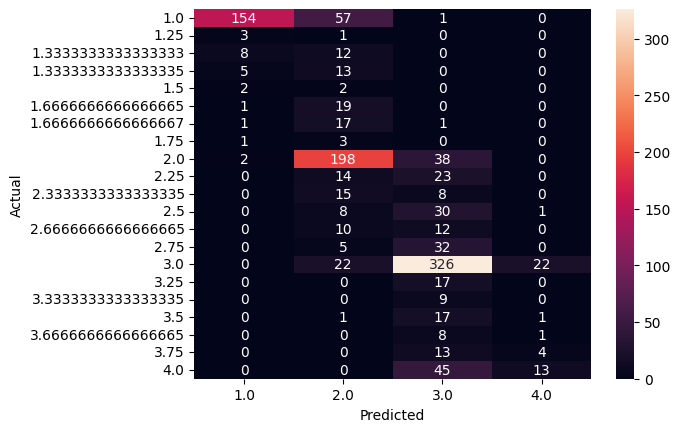

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[0.82426765 0.44402432 0.52198876 ... 0.66704654 0.76519401 0.99268948]


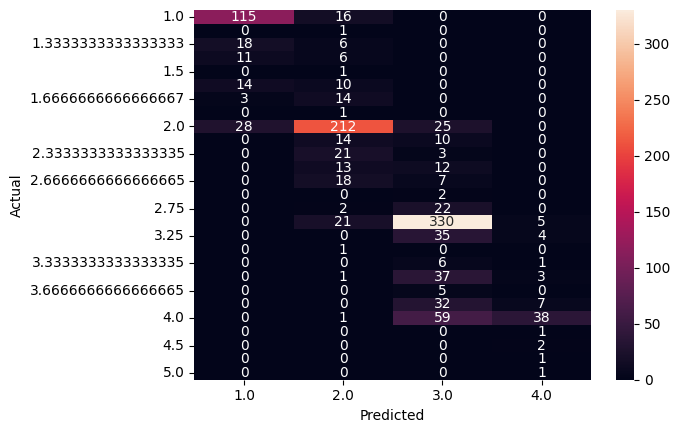

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[0.08617454 0.03215052 0.04372987 ... 0.31789801 0.447296   0.75929813]


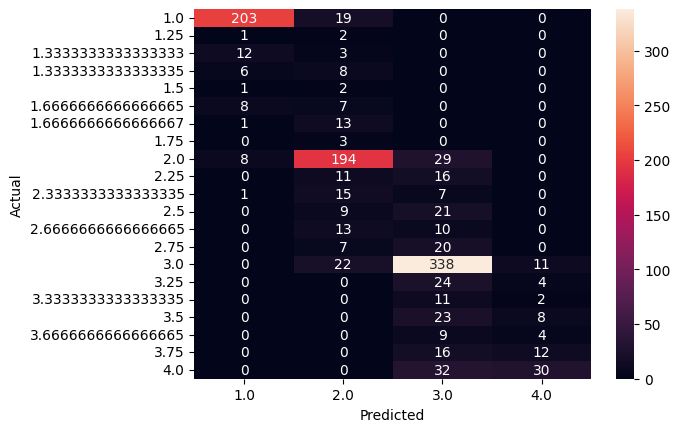

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[0.15223052 0.44811069 0.2352464  ... 0.26345481 0.10975153 0.32215109]


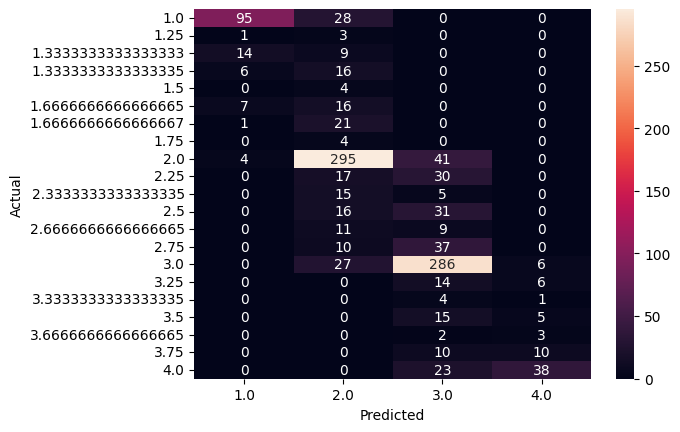

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[0.04297171 0.18679003 0.30340925 ... 0.20119993 0.26254802 0.28720882]


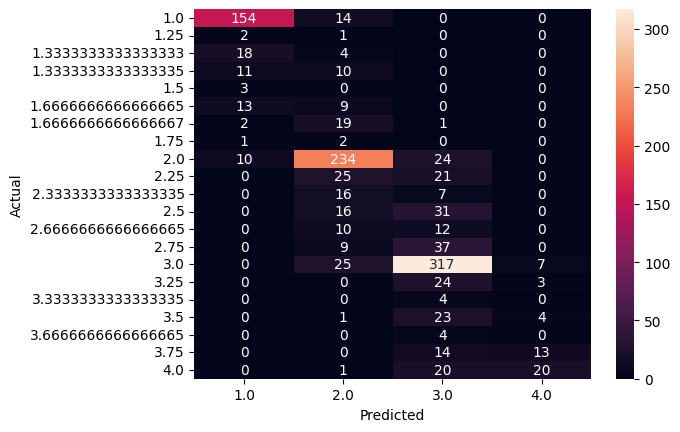

Mean MAE: 0.27
Mean R2: nan


Mean of empty slice.
invalid value encountered in scalar divide


<Figure size 640x480 with 0 Axes>

In [66]:
X = df_interpolated.iloc[:, -38:] # Define explanatory variables
y = df_interpolated[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
mae_values = list()
r2_values = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
#     X_train = X_train.dropna(axis=1, how='all').copy()
    X_test = X_test[X_train.columns]
    
    #Interpolate training data to generate more training points
#     X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
#     X_train.reset_index(level=0, drop=True, inplace=True)
#     y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
#     y_train.reset_index(level=0, drop=True, inplace=True)

    model = HistGradientBoostingRegressor()
    model.fit(X_train, y_train)

    y_pred= model.predict(X_test)

    # Append results to respective lists
    errors = (abs(y_pred - y_val['ipc'].to_numpy()))
    print(errors)
    errors = errors[~np.isnan(errors)]
    mae_values.append(np.mean(errors))

#     plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc'].to_numpy()) # Plot confusion matrix

print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2

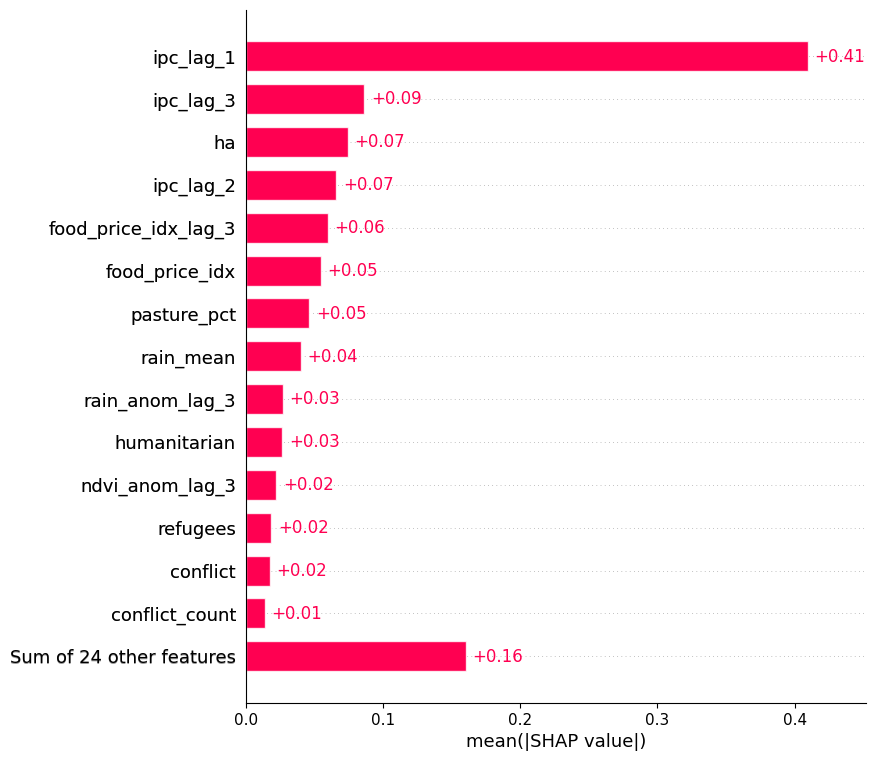

In [68]:
# !pip install shap
# !pip install numpy==1.24.4
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)
shap.plots.bar(shap_values, max_display=15)

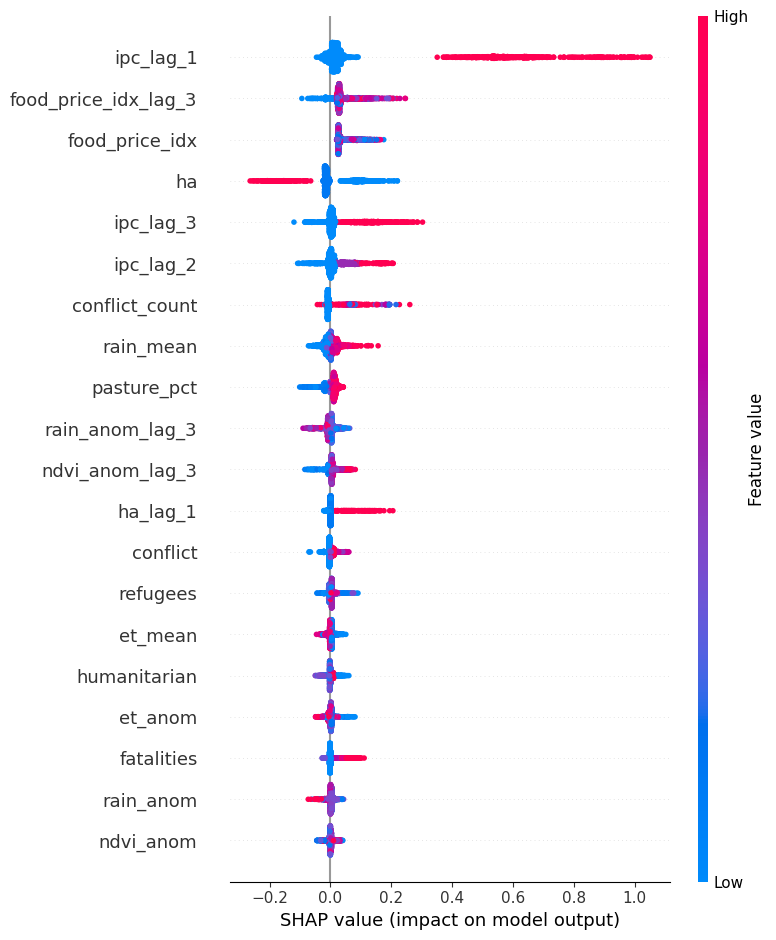

In [54]:
shap.summary_plot(shap_values, X_test)

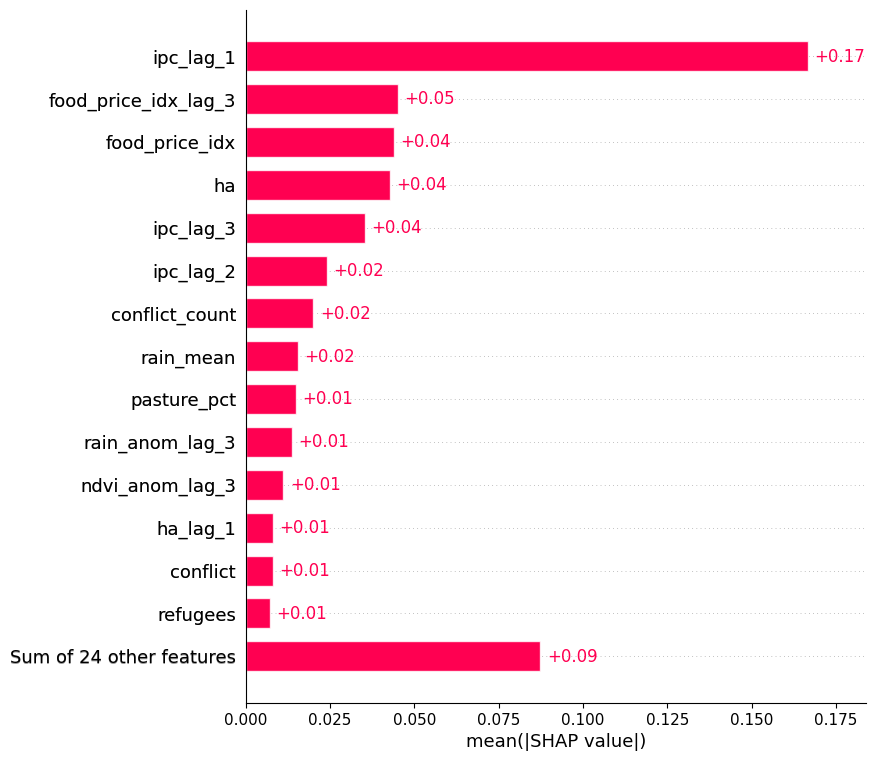

In [56]:
shap.plots.bar(shap_values, max_display=15)

## Sklearn regression

In [101]:
from sklearn.linear_model import LinearRegression
X = df_imputed.iloc[:, -30:] # Define explanatory variables
y = df_imputed[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
mae_values = list()
r2_values = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
#     X_train = X_train.dropna(axis=1, how='all').copy()
    X_test = X_test[X_train.columns]
    
    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    model =LinearRegression()
    model.fit(X_train, y_train)

    y_pred= model.predict(X_test)
    # Append results to respective lists
    errors = (abs(y_pred - y_val['ipc'].to_numpy()))
    errors = errors[~np.isnan(errors)]
    mae_values.append(np.mean(errors))

#     plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
#     plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc'].to_numpy()) # Plot confusion matrix
print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2

Mean MAE: 0.49
Mean R2: nan


Mean of empty slice.
invalid value encountered in scalar divide


Estimating transforms: 100%|██████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 637.13it/s]


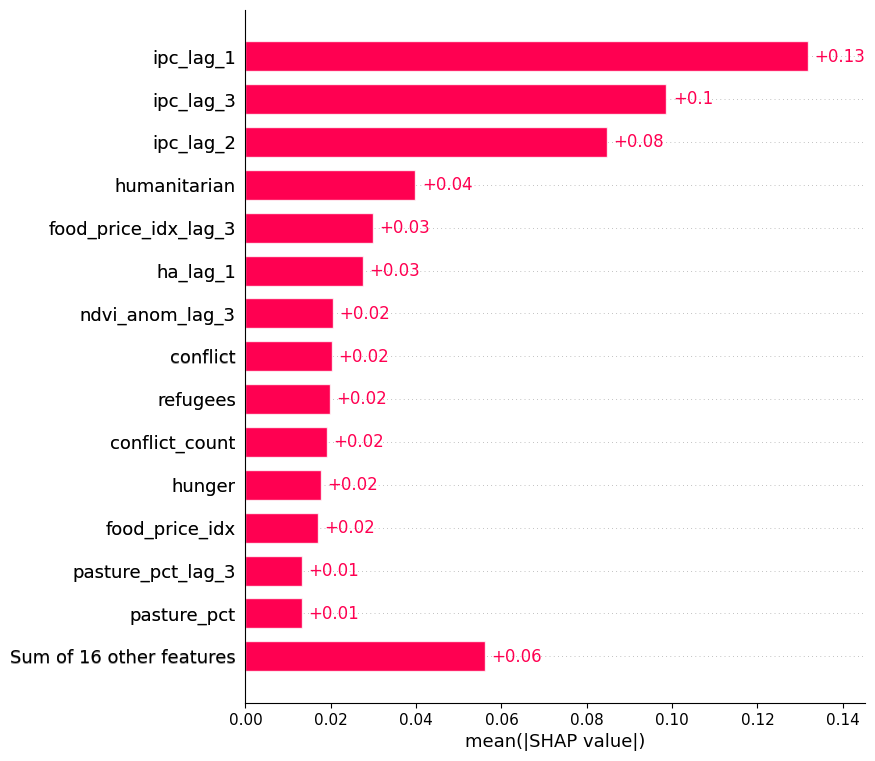

In [102]:
explainer = shap.LinearExplainer(model, masker=shap.maskers.Impute(X_test))
shap_values = explainer(X_test)
shap.plots.bar(shap_values, max_display=15)

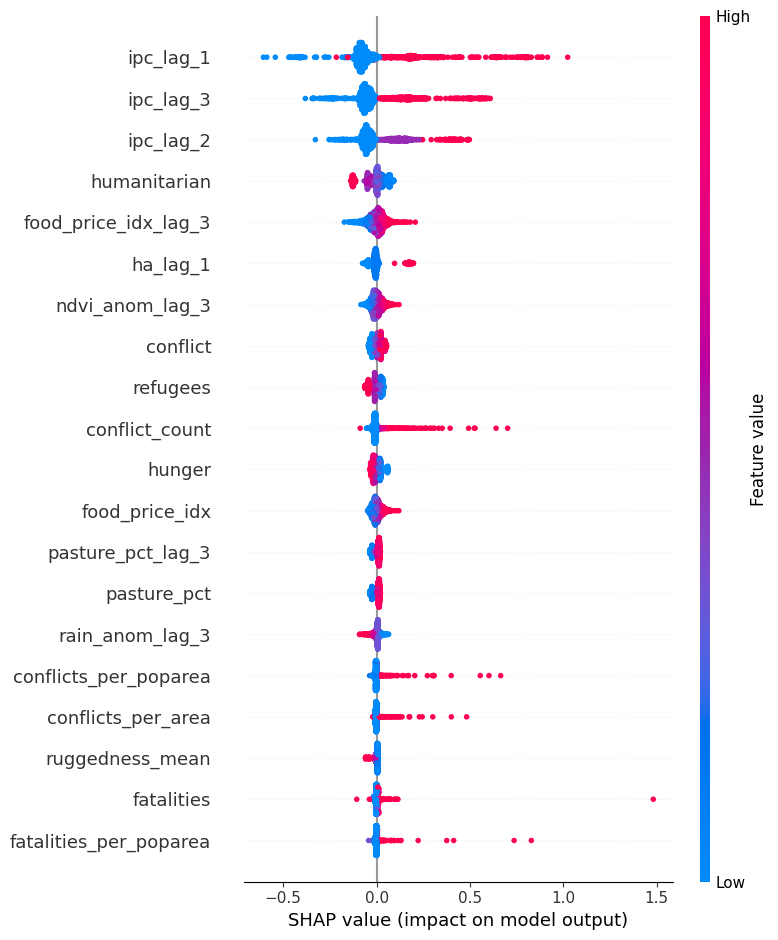

In [103]:
shap.summary_plot(shap_values, X_test)

## Statmodel OLS

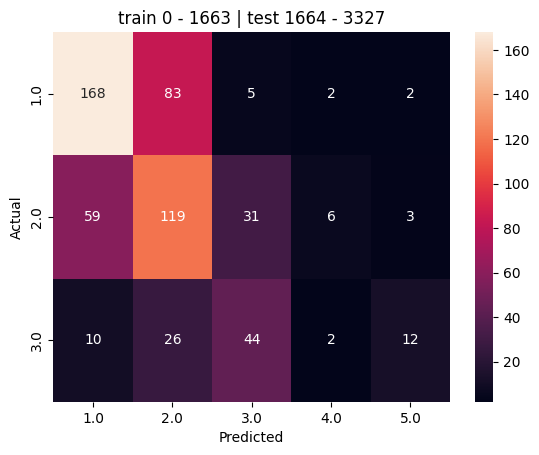

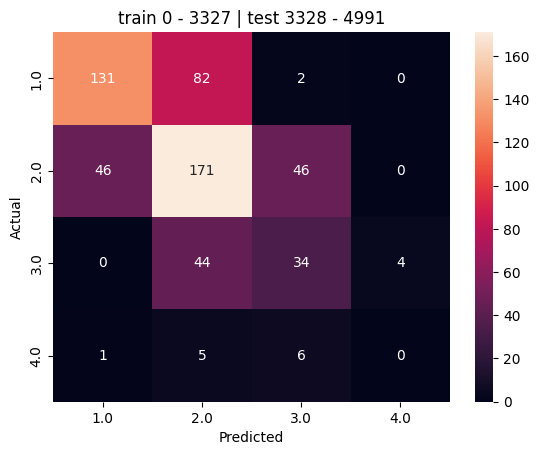

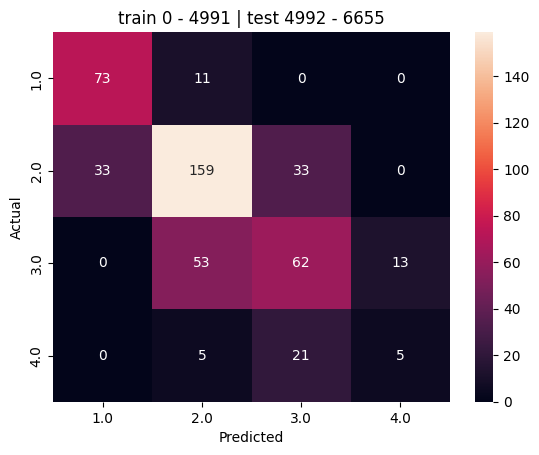

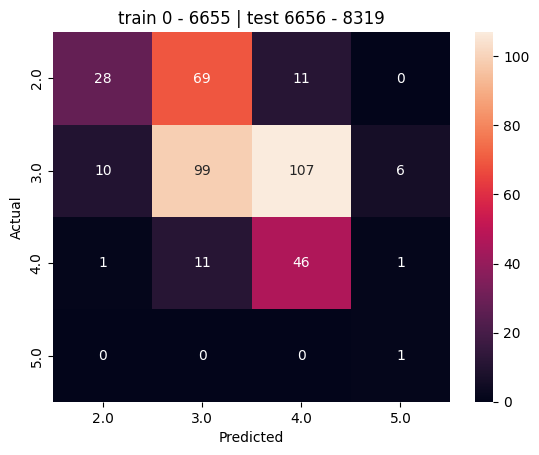

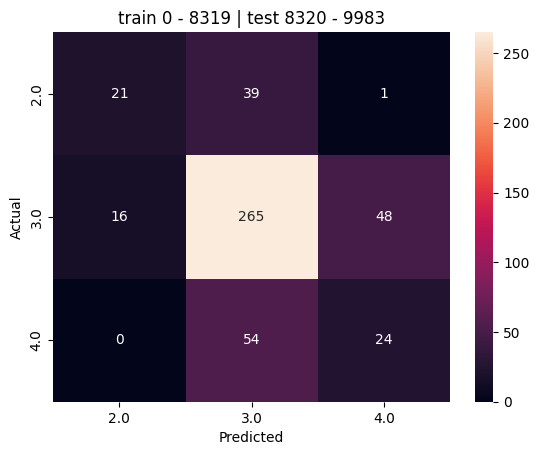

Mean MAE: 0.55
Mean R2: nan


Mean of empty slice.
invalid value encountered in scalar divide


<Figure size 640x480 with 0 Axes>

In [104]:
X = df_imputed.iloc[:, -30:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df_imputed[["ipc"]] # Define target data
X_raw = df.iloc[:, -30:] # Define explanatory variables
X_raw = sm.add_constant(X) # Add constant column of 1s for intercept
y_raw = df[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
mae_values = list()
r2_values = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X_raw.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y_raw.iloc[val_index]

    # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
    X_train = X_train.dropna(axis=1, how='all').copy()
    X_test = X_test[X_train.columns]

    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    model = OLS(y_train, X_train) # Initialize OLS model on training data
    
    results = model.fit() # Get model results on training data
#     print(results.summary()) # Print model summary

    y_pred = results.predict(X_test) # Run model on test data
    
    # Append results to respective lists
    mae_values.append((y_pred - y_val['ipc']).abs().mean())

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix
    
print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2

In [96]:

import shap


# Create an explainer for the wrapped model
explainer = shap.KernelExplainer(results.predict, shap.sample(X_test, 2))

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)


100%|██████████████████████████████████████████████████████████████████████████████| 1664/1664 [03:36<00:00,  7.67it/s]


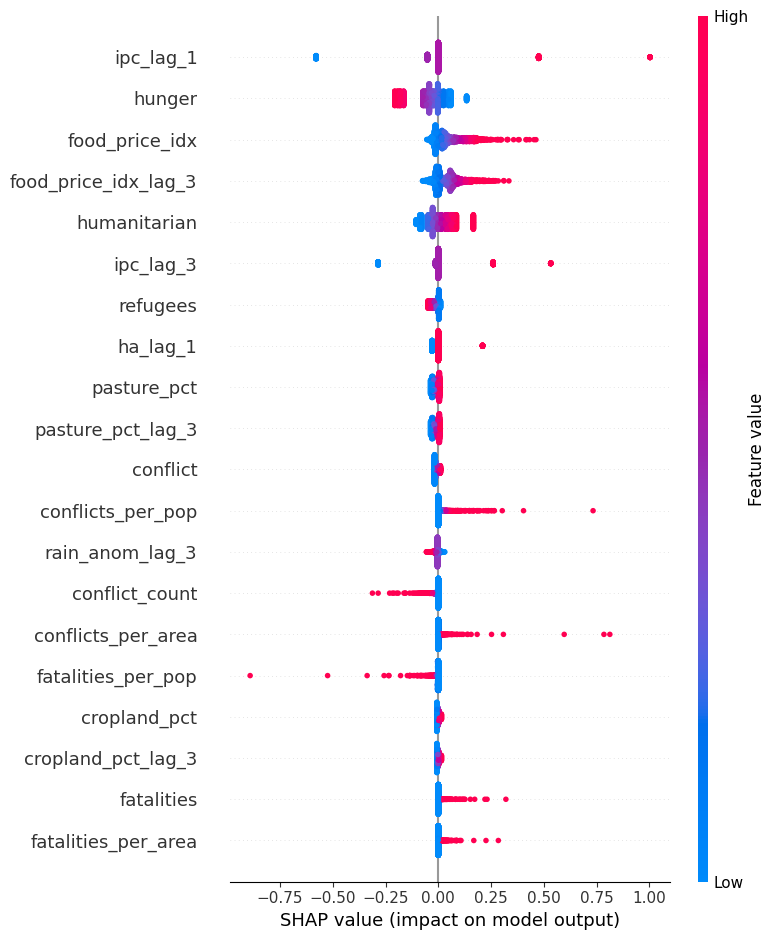

In [100]:
shap.summary_plot(shap_values, X_test)

We see that the R2 has risen somewhat compared to the baseline.

# Predicting crisis/no crisis

We can also transform the IPC prediction in a binary classification problem by considering IPC 3+ as crisis, and IPC 2- as no-crisis. Let's give a simple example

In [41]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column

## SKlearn classifiers

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


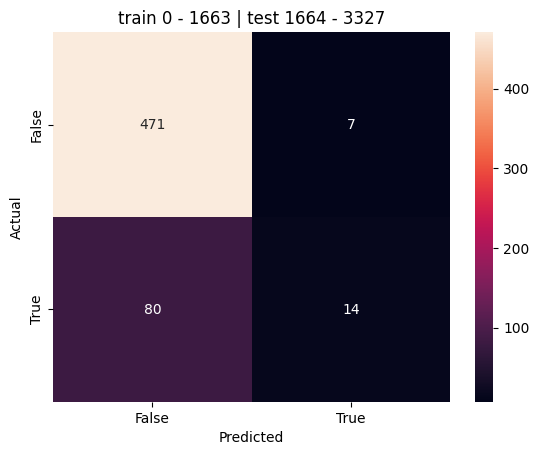

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


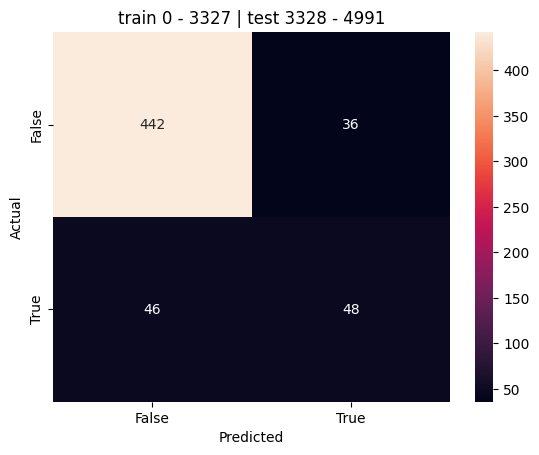

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


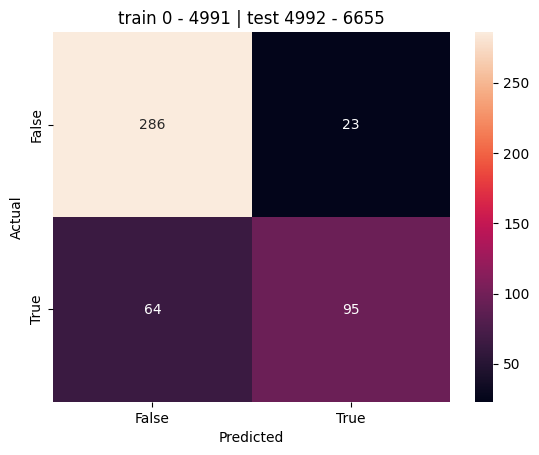

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


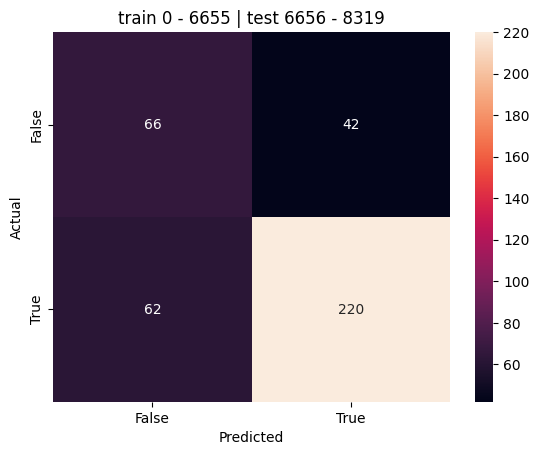

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


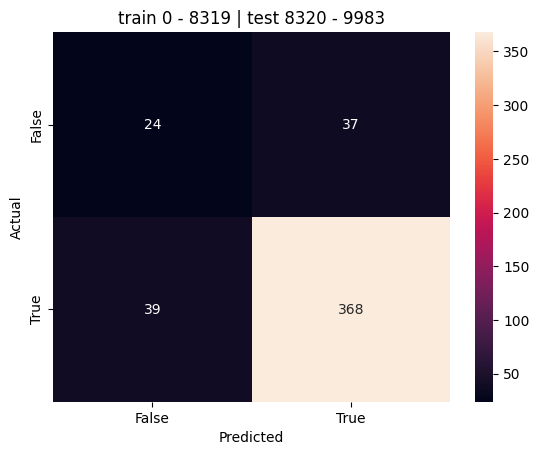

0.9064039408866995
Mean Acc: 0.82


<Figure size 640x480 with 0 Axes>

In [42]:
from sklearn.metrics import f1_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

df2 = df.copy()
X = df2.iloc[:, -30:] # Define explanatory variables
y = df2[["ipc"]] # Define target data
cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits
acc_values = list() # Initinalize empty lists to score accuracy scores

for train_index, val_index in cv.split(X): # Loop over the different training-test splits
    
    y_binary = y > 2 # Convert y to binary variable
    y_binary[y.isna()] = pd.NA # Conserve NaN values
    y_binary = y_binary.astype("float32") # Convert y to float

    X_train, X_test = X[['ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3']].iloc[train_index], X[['ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3']].iloc[val_index]
    y_train, y_val = y_binary.iloc[train_index], y_binary.iloc[val_index]

    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    #Drop nans
    train_ind = np.where(~X_train.isnull().any(axis=1))[0]
    val_ind = np.where(~X_test.isnull().any(axis=1))[0]
    
    X_train = X_train.iloc[train_ind]
    y_train = y_train.iloc[train_ind]

    X_test = X_test.iloc[val_ind]
    y_val = y_val.iloc[val_ind]

    model = LogisticRegression(random_state=1)
#     model = GradientBoostingClassifier(random_state=1)
    results = model.fit(X_train, y_train.round().astype(bool)) # Get model results on training data
    
    y_pred = results.predict(X_test) # Run model on test data

    # Convert prediction and validation to boolean
    y_pred = y_pred.round().astype(bool)
    y_val = y_val.round().astype(bool)

    # Drop all rows from prediction and validation where validation is null
    y_pred = y_pred[list(y_val.isnull()['ipc']==False)]
    y_val.dropna(inplace=True)

    acc_values.append(accuracy_score(y_val, y_pred)) # Append accuracy to list

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc'], binary = True) # Plot confusion matrix

print(f1_score(y_val['ipc'], y_pred))
print(f"Mean Acc: {np.mean(acc_values):.2f}") # Print Acc

## Logit (provided model)

In [43]:
X = df.iloc[:, -30:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits
acc_values = list() # Initinalize empty lists to score accuracy scores

X = sm.add_constant(X)

for train_index, val_index in cv.split(X): # Loop over the different training-test splits
    
    y_binary = y > 2 # Convert y to binary variable
    y_binary[y.isna()] = pd.NA # Conserve NaN values
    y_binary = y_binary.astype("float32") # Convert y to float

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y_binary.iloc[train_index], y_binary.iloc[val_index]
    
    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)
    
    cols = ['const', 'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3'] # Select columns to use in model
    model = sm.Logit(y_train, X_train[cols], missing="drop") # Initialize Logit model
    results = model.fit() # Get model results on training data
#     print(results.summary()) # Print model summary
    print(y_train)

    y_pred = results.predict(X_test[cols]) # Run model on test data

    # Convert prediction and validation to boolean
    y_pred = y_pred.round().astype(bool)
    y_val = y_val.round().astype(bool)

    # Drop all rows from prediction and validation where validation is null
    y_pred = y_pred[list(y_val.isnull()['ipc']==False)]
    y_val.dropna(inplace=True)

    acc_values.append(accuracy_score(y_val, y_pred)) # Append accuracy to list

#     plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
#     plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc'], binary = True) # Plot confusion matrix

print(f1_score(y_val['ipc'], y_pred))
print(f"Mean Acc: {np.mean(acc_values):.2f}") # Print Acc

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.


Optimization terminated successfully.
         Current function value: 0.023951
         Iterations 11
                       ipc
date       district       
2009-07-01 Abiemnhom   0.0
2009-08-01 Abiemnhom   0.0
2009-09-01 Abiemnhom   0.0
2009-10-01 Abiemnhom   0.0
2009-11-01 Abiemnhom   0.0
...                    ...
2010-11-01 Yirol West  0.0
2010-12-01 Yirol West  0.0
2011-01-01 Yirol West  0.0
2011-02-01 Yirol West  0.0
2011-03-01 Yirol West  0.0

[1664 rows x 1 columns]


Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.


Optimization terminated successfully.
         Current function value: 0.196510
         Iterations 8
                       ipc
date       district       
2009-07-01 Abiemnhom   0.0
2009-08-01 Abiemnhom   0.0
2009-09-01 Abiemnhom   0.0
2009-10-01 Abiemnhom   0.0
2009-11-01 Abiemnhom   0.0
...                    ...
2012-08-01 Yirol West  0.0
2012-09-01 Yirol West  0.0
2012-10-01 Yirol West  0.0
2012-11-01 Yirol West  0.0
2012-12-01 Yirol West  0.0

[3328 rows x 1 columns]


Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.


Optimization terminated successfully.
         Current function value: 0.220939
         Iterations 8
                       ipc
date       district       
2009-07-01 Abiemnhom   0.0
2009-08-01 Abiemnhom   0.0
2009-09-01 Abiemnhom   0.0
2009-10-01 Abiemnhom   0.0
2009-11-01 Abiemnhom   0.0
...                    ...
2014-06-01 Yirol West  0.0
2014-07-01 Yirol West  0.0
2014-08-01 Yirol West  0.0
2014-09-01 Yirol West  0.0
2014-10-01 Yirol West  0.0

[4992 rows x 1 columns]


Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.


Optimization terminated successfully.
         Current function value: 0.263542
         Iterations 7
                        ipc
date       district        
2009-07-01 Abiemnhom   0.00
2009-08-01 Abiemnhom   0.00
2009-09-01 Abiemnhom   0.00
2009-10-01 Abiemnhom   0.00
2009-11-01 Abiemnhom   0.00
...                     ...
2016-03-01 Yirol West  0.25
2016-04-01 Yirol West  0.50
2016-05-01 Yirol West  0.75
2016-06-01 Yirol West  1.00
2016-07-01 Yirol West  1.00

[6656 rows x 1 columns]


Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.


Optimization terminated successfully.
         Current function value: 0.297659
         Iterations 7
                       ipc
date       district       
2009-07-01 Abiemnhom   0.0
2009-08-01 Abiemnhom   0.0
2009-09-01 Abiemnhom   0.0
2009-10-01 Abiemnhom   0.0
2009-11-01 Abiemnhom   0.0
...                    ...
2017-12-01 Yirol West  1.0
2018-01-01 Yirol West  1.0
2018-02-01 Yirol West  1.0
2018-03-01 Yirol West  1.0
2018-04-01 Yirol West  1.0

[8320 rows x 1 columns]
0.9762796504369537
Mean Acc: 0.95
